<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf


Tensorflow version: 2.12.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [7]:
data = pd.read_csv("C:\\Users\\Admin\\Desktop\\B21AI001\\DL\\lab7\\ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [9]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [10]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [11]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [13]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
word2idx

{'Whitney': 1,
 'supplement': 2,
 'crocodile': 3,
 'Ciudad': 4,
 'already': 5,
 'One': 6,
 'ammunition': 7,
 'hosting': 8,
 'agreeing': 9,
 'Ramechhap': 10,
 'facility': 11,
 'normalcy': 12,
 'evolution': 13,
 'Sierra': 14,
 'G20': 15,
 'clan': 16,
 'Lao': 17,
 'sometimes': 18,
 'unfold': 19,
 'testified': 20,
 'cavity': 21,
 'NATO-funded': 22,
 'Latgalians': 23,
 'bet': 24,
 'readmitted': 25,
 'encampment': 26,
 'apologizes': 27,
 'counter': 28,
 'profitable': 29,
 'negotiate': 30,
 'Johann': 31,
 'Al-Adha': 32,
 'Stethem': 33,
 'Jebel': 34,
 'Aboriginal': 35,
 'Krivtsov': 36,
 'leased': 37,
 'Leipzig': 38,
 'iron-ore': 39,
 'jailings': 40,
 'loss': 41,
 'Israeli-Egyptian': 42,
 'Michuki': 43,
 'But': 44,
 '77,000': 45,
 'infrastructure': 46,
 'hyperinflation': 47,
 'pure': 48,
 'shareholders': 49,
 'postcard': 50,
 'three-week': 51,
 'antagonist': 52,
 'bat': 53,
 'mid-year': 54,
 'Pozarevac': 55,
 'Khyber-Pakhtunkhwa': 56,
 'marathon': 57,
 'mused': 58,
 'highway': 59,
 'monitored':

### Task 5: Padding Input Sentences and Creating Train/Test Splits

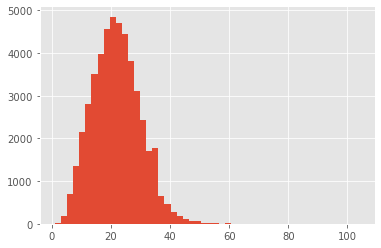

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Task 6: Build and Compile a Bidirectional LSTM Model

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

## Bidirectional RNN Model

In [22]:
from tensorflow.keras.layers import SimpleRNN

# Define the input layer
input_word = Input(shape=(max_len,))

# Embedding layer
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)

# Spatial dropout layer
model = SpatialDropout1D(0.1)(model)

# Bidirectional RNN layer
model = Bidirectional(SimpleRNN(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# TimeDistributed Dense layer
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)

# Define the model
model = Model(input_word, out)

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Print model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 200)          30200     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 17)           3417      
 tributed)                                                       
                                                           

In [23]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [25]:
pip install livelossplot


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



### Task 7: Train the Model

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

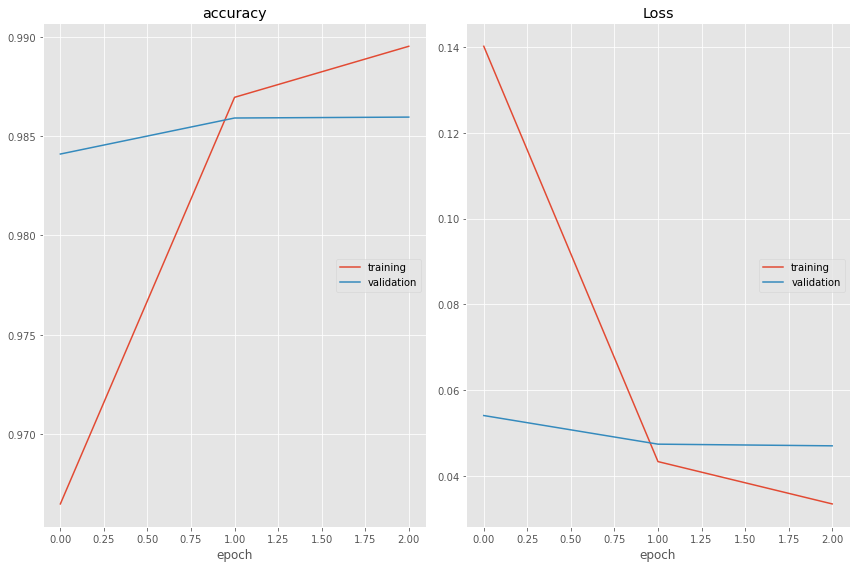

accuracy
	training         	 (min:    0.966, max:    0.990, cur:    0.990)
	validation       	 (min:    0.984, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.033, max:    0.140, cur:    0.033)
	validation       	 (min:    0.047, max:    0.054, cur:    0.047)

Epoch 3: val_loss improved from 0.04740 to 0.04701, saving model to model_weights.h5
1199/1199 [==============================] - 40s 33ms/step - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.0470 - val_accuracy: 0.9860
CPU times: total: 1min 34s
Wall time: 1min 59s


In [27]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [28]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 1s 4ms/step - loss: 0.0470 - accuracy: 0.9860


[0.04700823128223419, 0.9859591126441956]

In [29]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 160ms/step
Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility    O	O
possibility  